In [43]:
# the purpose of this notebook is to work our stability prolems associated with writing
# q in terms of Q/W

First, the math that we want to use here is the following:

1. Anywhere $q$ appears in the model should be replaced with $\frac{Q}{W}$
2. This means that we first need to calculate $W$
> from Wickert and Schildgen 2019: $W = \frac{k_b Q S^{7/6}}{D^{3/2}}$

>> so, anywhere that $q$ appears, we can just sub in $\frac{D^{3/2}}{k_b S^{7/6}}$

>> maybe the best way to do this is to include a line in our main loop, right after calculating slope, that is $q = \frac{D^{3/2}}{k_b S^{7/6}}$

Thoughts on stability issues:
- from doing some testing, part of the issue comes from using $rk_hx^2$ for Q. If we go back to a unit discharge case, using this formulation for $q$ can stay stable to create a concave-up profile, but requires really tiny timesteps $(\sim10^{-4})$ and doesn't get all the way to steady state

- If we use $rk_hx^2$ for Q and make the substitutions outlined above, slopes get unstable (nan) very quickly $(\sim10-20 \space \text {timesteps})$

- I don't understand why things become unstable, instead of just shrinking to such tiny timesteps that the program can't evolve

- I've tested the model over small time increments to figure out when things become unstable. If I coarsen the grid (i.e., make `dx_2` larger), I'm still unable to reach steady conditions, and I'm not sure if changing my grid size is a good way to go about finding bugs... (don't know how useful it is to find a condition where the model can be stable if it's dramtically different from the grid and domain size that I plan to use going forward).

In [44]:
# start by importing libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [66]:
# SET UP GRID ARRAYS
dx_2 = 1000
x_2 = np.arange(0, 100000, dx_2)

# set up references to topography
Hstar_2 = 0.1
H_2 = Hstar_2 + np.zeros(len(x_2))

etab_2 = np.zeros(len(x_2))
etab_2[:] = np.linspace(1000, 0.1, len(x_2))

eta_2 = etab_2 + H_2

# abrasion coefficients from Attal and Lave 2006 in % per km
beta_ig_2 = np.zeros(len(x_2))
beta_ig_2[:25] = 0.00004
beta_sed_2 = np.zeros(len(x_2))
beta_sed_2[25:] = 0.00014
atr_factor_2 = 0.00004

# erodibility values
k_ig_2 = np.zeros(len(x_2))
k_ig_2[:25] = 0.0001
k_sed_2 = np.zeros(len(x_2))
k_sed_2[25:] = 0.001

# grainsize
D_1 = 0.2
D_2 = 0.3

In [67]:
# write a function that has two bedrock lithologies in the domain, but only one contributing sediment to bedload
def two_lith_one_sed(x,
                     dx,
                     Hstar,
                     H,
                     etab,
                     eta,
                     beta_ig,
                     beta_sed,
                     atr_factor,
                     k_ig,
                     k_sed,
                     D,
                     c = 1,
                     baselevel_rate = 0.001,
                     num_steps = 500000, 
                     porosity = 0.55):
    
    kb = 8.3e-8 # 2.61 # wickert and schildgen width coefficient
    kh = 0.3 # basin geometry factor
    r = 0.3 # runoff rate
    W = np.zeros(len(x))
    W[0] = 0
    H[-1] = 0.0
    bedrock_ero = np.zeros(len(x))  # bedrock erosion rate
    sedimentation_rate = np.zeros(len(x))
    total_ero = np.zeros(len(x))
    total_ero[-1] = baselevel_rate
    
    # define total dischage and create arrays to hold unit discharge
    Q = r * kh * x**2
    q = np.zeros(len(x))
    q[0] = 0
    
    qs = np.zeros(len(x))  # first node is left edge of 0th cell
    dt_global = 0.2 * (0.2 * dx * dx / (c*Q[-1]))  # "global" time-step size
    run_duration = dt_global * num_steps  # <== here's how long we want to run
    cum_time = 0.0  # <== keep track of elapsed time

    #for i in range(num_steps):
    while cum_time < run_duration:  # <== use a while loop because dt varies by iteration
        

        # first calculate rates
        
        #  calc slope
        S = -np.diff(eta)/dx
        
        # calc width
        W[1:] = (kb * Q[1:] * S**(7/6)) / (D**(3/2))
        
        # calc q
        q[1:] = (D**(3/2)) / (kb * (S**(7/6)))
        
        #  calculate e factor
        efac = np.exp(- H / Hstar)
        
        #  calculate total bedload sed flux and set boundary condition
        qs[1:] = ((c * D**(3/2)) / (kb * (S**(1/6)))) * (1.0 - efac[:-1])
        qs[0] = 0
        
        #  calc bedrock erosion from stream power (plucking)
        ero_plucking_ig = efac[:-1] * (k_ig[1:] * q[1:] * S)
        ero_plucking_sed = efac[:-1] * (k_sed[1:] * q[1:] * S)
        
        #  calc bedrock erosion from abrasion
        ero_ab_ig = efac[:-1] * (beta_ig[:-1] * qs[1:])   # <== change indexing: qs[1] represents node 0
        ero_ab_sed = efac[:-1] * (beta_sed[:-1] * qs[1:])
        
        #  calc bedrock erosion rate from stream power and abrasion
        bedrock_ero[:-1] = ero_plucking_ig + ero_plucking_sed + ero_ab_ig + ero_ab_sed
        
        #  calc grain attrition rate
        atr = atr_factor * qs[1:]
        
        #  calc rate of change in alluvial thickness
        sedimentation_rate[:-1] = -((1 / porosity) * ((np.diff(qs)/dx) + atr - ero_plucking_ig))
        
        
        # Calculate maximum allowable time-step size
        
        #  track total erosion rate
        total_ero[:-1] = bedrock_ero[:-1] - sedimentation_rate[:-1]  # <== erosion is MINUS sed rate
        
        #  set adaptive timestep
        #  first check time to flat surface
        elev_diff = np.diff(eta)/dx
        ero_diff = np.diff(total_ero)/dx
        #valid_places = np.where(ero_diff < 0)
        valid_places = np.where(ero_diff < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(valid_places) > 0:  # <== in case there ARE no locations...
            times_to_flat = np.abs(elev_diff[valid_places]/ero_diff[valid_places])
        else:
            times_to_flat = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_flat = np.amin(times_to_flat)

        #  then check time to deplete all sediment
        #sed_depletion_locations = np.where(sedimentation_rate < 0)
        sed_depletion_locations = np.where(sedimentation_rate < 0)[0]  # <== we just want the array, not the full tuple from where()
        if len(sed_depletion_locations) > 0:  # <== in case there ARE no locations...
            times_to_no_sed = np.abs(H[sed_depletion_locations]/sedimentation_rate[sed_depletion_locations])
        else:
            times_to_no_sed = np.array([dt_global])  # <== ...we just revert to the global dt
        min_time_to_no_sed = np.amin(times_to_no_sed)

        #  check for smaller condition
        dt = min(min_time_to_flat, min_time_to_no_sed)

        #  if larger than global step size, limit to global
        dt = min(dt, dt_global)
        
        
        # Update quantities
        
        #  lower baselevel
        eta[-1] -= baselevel_rate * dt 
        
        #  set boundary conditions
        etab[-1] = eta[-1]
        
        #  calc change in bedrock elev
        etab[:-1] -= bedrock_ero[:-1] * dt
        
        #  update sediment thickness
        H[:-1] += sedimentation_rate[:-1] * dt
        H[H < 0] = 0

        #  update elev
        eta[:-1] = etab[:-1] + H[:-1]
        
        # Advance time
        cum_time += dt
        
        if any(total_ero[:] != baselevel_rate):
            continue
        else:
            break
            
    print('cumulative time (yrs): ', cum_time)
    print('timestep used: ', dt)
        
    return (S, W, q, qs, efac, eta, etab, ero_plucking_ig, ero_plucking_sed, ero_ab_ig, ero_ab_sed, bedrock_ero, 
            atr, sedimentation_rate, H, total_ero, cum_time)

In [76]:
# design an input experiment
# run for just one timestep
two_lith_20cm = [x_2, 
                 dx_2, 
                 Hstar_2, 
                 H_2, 
                 etab_2, 
                 eta_2, 
                 beta_ig_2, 
                 beta_sed_2, 
                 atr_factor_2, 
                 k_ig_2, 
                 k_sed_2, 
                 D_1,
                 1,
                 0.001,
                 1000]

# run the experiment to ss
(slope_TL_20,
 width_TL_20,
 q_TL_20,
 qs_TL_20,
 e_factor_TL_20,
 topo_TL_20,
 bedrock_elev_TL_20,
 ig_plucking_rate_TL_20,
 sed_plucking_rate_TL_20,
 ig_abrasion_rate_TL_20,
 sed_abrasion_rate_TL_20,
 bedrock_ero_rate_TL_20,
 attrition_rate_TL_20,
 sedimentation_rate_TL_20,
 h_TL_20,
 total_ero_rate_TL_20,
 cum_time_TL_20) = two_lith_one_sed(*two_lith_20cm)

cumulative time (yrs):  5.487833264164916
timestep used:  0.005486968449931413


/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide
/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in multiply
/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in multiply
/Users/vanessa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in multiply


In [77]:
print(slope_TL_20)

[nan nan nan nan nan nan nan nan nan]


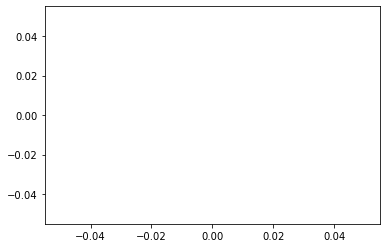

In [78]:
plt.plot(x_2[1:], slope_TL_20)

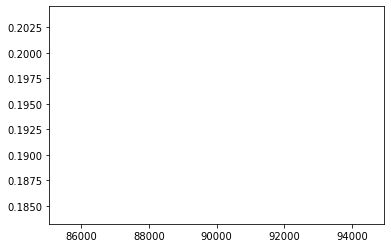

In [79]:
plt.plot(x_2, topo_TL_20)